In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

sns.set()

# Load results

To regenerate the benchmarking results from scratch, follow the instructions in README to set up data and submit all benchmarking jobs.

Alternatively, if you do not wish to rerun all experiments, but only want to generate the plots, we also provide the results we used. Simply extract the results from the provided archive file under the project root directory by

```
$ tar -xzvf results.tar.gz
```

In [2]:
dfs = []
for i in glob.glob("../results/*.json"):
    name = i.split("/")[-1].split(".json")[0]
    new_df = pd.read_json(i)
    new_df["network"], new_df["label"], new_df["model"], new_df["rep"] = name.split("_")
    dfs.append(new_df)
df = pd.concat(dfs)
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,model,rep
0,DOID:10124,0.004545,-0.242939,-0.074184,0.494854,0.410504,0.447248,humannet,disgenet,gat,2
1,DOID:76,0.072780,0.341915,0.076670,0.495112,0.555295,0.477872,humannet,disgenet,gat,2
2,DOID:26,-0.098731,0.367891,0.094019,0.474564,0.516022,0.481628,humannet,disgenet,gat,2
3,DOID:0060032,-0.096801,0.047014,0.119272,0.490923,0.536376,0.490060,humannet,disgenet,gat,2
4,DOID:0060158,-0.045253,0.381350,0.581044,0.453043,0.462096,0.458034,humannet,disgenet,gat,2
...,...,...,...,...,...,...,...,...,...,...,...
118,DOID:9834,2.892218,1.088101,1.157919,0.831366,0.712271,0.661645,string,disgenet,n2v-svm,2
119,DOID:6419,4.257474,1.947520,0.194243,0.913556,0.658296,0.511282,string,disgenet,n2v-svm,2
120,DOID:8534,2.328611,1.184670,1.049223,0.819537,0.660646,0.692394,string,disgenet,n2v-svm,2
121,DOID:9370,3.412577,0.906294,0.827968,0.836918,0.564113,0.648607,string,disgenet,n2v-svm,2


In [3]:
networks = [
    "biogrid",
    "humannet",
    "string",
]
labels = ["disgenet", "gobp"]
models = [
    "adj-logreg",
    "adj-svm",
    "n2v-logreg",
    "n2v-svm",
    "labelprop",
    "gin",
    "gcn",
    "graphsage",
    "gat",
]

# Metric to plot
metric = "test_log2pr"

## Compare model performance across datasets

In [4]:
table = (
    df
    .groupby(["label", "network", "model"])
    .mean()[metric]
    .unstack("model")[models]
)

table.index = table.index.map("-".join)
table.index.name = table.columns.name = None
table.style.highlight_max(color="lightgreen", axis=1)

,adj-logreg,adj-svm,n2v-logreg,n2v-svm,labelprop,gin,gcn,graphsage,gat
disgenet-biogrid,0.773919,0.641985,0.741781,0.678801,0.812591,0.534996,0.489414,0.374360,0.344050
disgenet-humannet,1.898492,1.771644,1.669344,1.594309,1.879286,1.156724,0.905231,0.592143,0.381305
disgenet-string,2.603984,2.596474,2.032428,2.119376,2.589152,1.284286,1.115220,0.723065,nan
gobp-biogrid,1.686189,1.463769,1.845561,1.710385,1.243828,0.870020,0.940500,0.764127,0.317502
gobp-humannet,3.412612,3.271603,3.447859,3.331931,3.294328,2.260294,1.780476,1.168002,0.369709
gobp-string,3.481325,3.470233,3.354543,3.511456,3.403385,2.305623,1.914556,1.606290,nan


In [5]:
# Standard deviation across repetitions (each reduced via mean)
(
    df
    .groupby(["label", "network", "model", "rep"])
    .mean()
    .groupby(["label", "network", "model"])
    .std()[metric]
    .unstack("model")[models]
)

model              adj-logreg   adj-svm  n2v-logreg   n2v-svm  labelprop  \
label    network                                                           
disgenet biogrid          0.0  0.000002    0.038150  0.036046        0.0   
         humannet         0.0  0.000001    0.043889  0.029016        0.0   
         string           0.0  0.000001    0.035210  0.027848        0.0   
gobp     biogrid          0.0  0.000004    0.035232  0.038060        0.0   
         humannet         0.0  0.000003    0.021538  0.036137        0.0   
         string           0.0  0.000010    0.019607  0.036202        0.0   

model                   gin       gcn  graphsage       gat  
label    network                                            
disgenet biogrid   0.033146  0.043964   0.034955  0.065935  
         humannet  0.084814  0.074305   0.061607  0.034839  
         string    0.046119  0.029505   0.120805       NaN  
gobp     biogrid   0.037146  0.036594   0.022763  0.027924  
         humannet  0.052921  0.078306   0.125034  0.026063  
         string    0.085022  0.121557   0.221035       NaN

In [6]:
# Generate main result tables for manuscript
if False:  # replace with True to enable
    grouped = (
        df
        .groupby(["label", "network", "model", "rep"])
        .mean()
        .groupby(["label", "network", "model"])
    )

    mean_df = grouped.mean()[metric].unstack("label")
    std_df = grouped.std()[metric].unstack("label")

    model_name_dict = {
        "adj-logreg": "Adj-LogReg",
        "adj-svm": "Adj-SVM",
        "n2v-logreg": "N2V-LogReg",
        "n2v-svm": "N2V-SVM",
        "labelprop": "LabelProp",
        "gin": "GIN",
        "gcn": "GCN",
        "graphsage": "GraphSAGE",
        "gat": "GAT",
    }

    for network in networks:
        print(network, mean_df.columns.values)

        mean = mean_df.query("network == 'humannet'").reset_index("network", drop=True).loc[models]
        std = std_df.query("network == 'humannet'").reset_index("network", drop=True).loc[models]
        for (i, m), (_, s) in zip(mean.iterrows(), std.iterrows()):
            print(f"{model_name_dict[i]} & " + " & ".join([f"{x:.2f} ± {y:.2f}" for x, y in zip(m, s)]) + r"\\")

        print()

## Distribution of performance per task for a particular dataset

In [7]:
network = "humannet"
label = "disgenet"

summary_df = (
    df
    .groupby(
        ["task_name", "network", "label", "model"],
        as_index=False,
    )
    .mean()
    .query("network == @network & label == @label")
)
summary_df

,task_name,network,label,model,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
9,DOID:0050117,humannet,disgenet,adj-logreg,4.241086,3.916113,4.534222,1.000000,0.751801,0.780205
10,DOID:0050117,humannet,disgenet,adj-svm,4.241086,3.823437,4.535368,1.000000,0.751057,0.785740
11,DOID:0050117,humannet,disgenet,gat,0.297951,0.458779,0.302387,0.534841,0.531273,0.522365
12,DOID:0050117,humannet,disgenet,gcn,1.820467,1.673037,1.453464,0.744224,0.654558,0.690313
13,DOID:0050117,humannet,disgenet,gin,3.016837,2.334028,3.591089,0.860104,0.649359,0.694398
...,...,...,...,...,...,...,...,...,...,...
3185,DOID:9993,humannet,disgenet,gin,4.783028,2.768304,3.878911,0.953608,0.713008,0.691559
3186,DOID:9993,humannet,disgenet,graphsage,4.175170,3.277242,1.627762,0.875964,0.736152,0.585724
3187,DOID:9993,humannet,disgenet,labelprop,5.468892,3.303072,3.983153,1.000000,0.833928,0.701178
3188,DOID:9993,humannet,disgenet,n2v-logreg,4.623920,3.440205,3.469215,0.959948,0.803470,0.693181


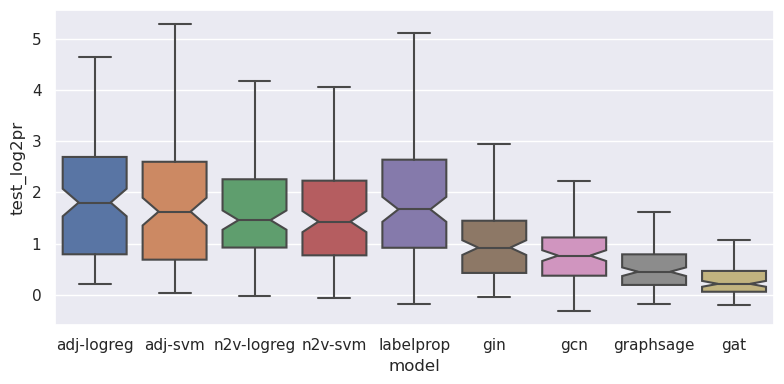

In [8]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=summary_df,
    x="model",
    y=metric,
    order=models,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

In [9]:
table = summary_df.pivot(index="task_name", columns="model", values=metric)
table

model,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop,n2v-logreg,n2v-svm
task_name,,,,,,,,,
DOID:0050117,4.534222,4.535368,0.302387,1.453464,3.591089,0.472657,4.668853,4.853740,4.845606
DOID:0050453,4.336055,4.368982,0.150165,0.972686,2.164441,-0.061131,3.965366,2.131783,2.318272
DOID:0050567,1.143653,0.641946,-0.033113,0.465764,0.879071,0.194514,1.466867,1.100619,1.200053
DOID:0050615,0.800005,0.803527,0.182167,0.335233,0.673395,0.278022,0.486473,1.882977,1.856286
DOID:0050621,0.798531,0.455129,0.237876,0.319501,1.003506,0.552551,0.603695,0.025213,0.160578
...,...,...,...,...,...,...,...,...,...
DOID:9834,2.025048,1.832410,0.059048,1.057582,1.356837,0.543443,1.083740,1.282745,1.187912
DOID:9835,1.946378,1.719785,0.045719,0.692218,1.079872,0.395110,1.722404,1.216856,1.271952
DOID:9840,2.397226,2.279186,0.112305,1.647684,2.530879,0.791483,1.947332,2.436752,2.029474


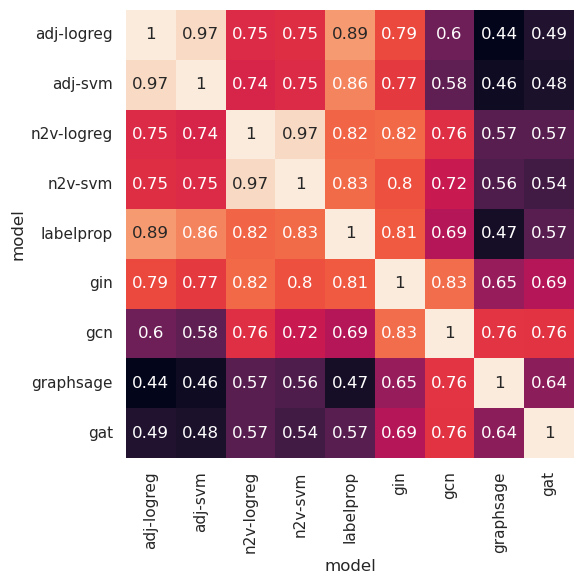

In [10]:
# Correlation of task-specific performance between models
plt.figure(figsize=(6, 6))
sns.heatmap(
    table[models].corr(),
    annot=True,
    cbar=False,
)
plt.tight_layout()
plt.show()

## Given a model and the tasks of interest, which network to use

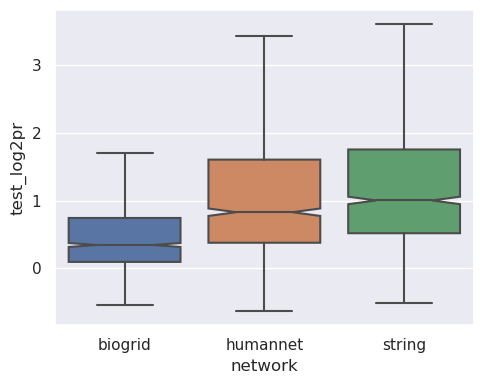

In [11]:
model = "gin"
label = "disgenet"
metric = "test_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

## No universally optimal model

In [12]:
network = "humannet"
label = "disgenet"

sub_df = df.query("network == @network & label == @label")

In [13]:
mdl1 = "adj-logreg"
mdl2 = "gcn"

score_lst = []
for task, group_task in sub_df.groupby("task_name"):
    group_task_mdl = group_task.groupby("model")
    
    mdl1_scores = group_task_mdl.get_group(mdl1)[metric].values
    mdl2_scores = group_task_mdl.get_group(mdl2)[metric].values
    
    diff_score = mdl1_scores.mean() - mdl2_scores.mean()
    pval = scipy.stats.ttest_ind(mdl1_scores, mdl2_scores)[1]
    
    score_lst.append((task, mdl1_scores.mean(), mdl2_scores.mean(), diff_score, pval))
    
pd.DataFrame(score_lst).sort_values(3).rename(
    columns={
        0: "task_name",
        1: mdl1,
        2: mdl2,
        3: f"{mdl1} - {mdl2}",
        4: "p-value",
    }
)

,task_name,adj-logreg,gcn,adj-logreg - gcn,p-value
43,DOID:12215,1.139275,2.305145,-1.165870,9.171324e-07
64,DOID:1934,0.504471,1.524574,-1.020103,1.871173e-05
50,DOID:1426,0.373629,1.175292,-0.801664,8.181133e-02
49,DOID:13832,0.396298,0.983882,-0.587585,4.870882e-08
91,DOID:480,0.398559,0.973049,-0.574490,5.255507e-06
...,...,...,...,...,...
114,DOID:9500,3.706410,0.618835,3.087575,4.201089e-18
110,DOID:9252,5.858867,2.600130,3.258737,1.779444e-13
87,DOID:4079,3.229803,-0.083708,3.313512,1.185873e-21
108,DOID:8501,5.623820,2.284376,3.339444,3.771055e-09
